In [ ]:
# !!!! ALL OUTDATED!!!!
# # shared link: https://colab.research.google.com/drive/1khwU28e9mhMoHX_YQoHzlsybiW78j1Rd?usp=sharing
# from google.colab import drive
# drive.mount("/content/drive")

# # by defaults pwd = /content/
# # so now go to /content/drive/MyDrive/ to see ur own files

In [ ]:
# # DOWNLOAD DATA AND SAVE IN DRIVE (ONLY ONCE)

# !rsync rsync://176.9.41.242:873/danbooru2021/filelist.txt.xz ./

# dataset:
# https://www.gwern.net/Danbooru2021#image-metadata

# paper:
# https://arxiv.org/abs/1704.08834
# https://www.gwern.net/docs/www/arxiv.org/df1fce771360e3b6eda5ddb16a09ec1022fffb32.pdf

# !rsync --recursive --size-only --verbose rsync://176.9.41.242:873/danbooru2021/ ./danbooru2021/


# # Obtain kaggle.json file via https://www.kaggle.com/general/74235

# !pip install -q kaggle
# from google.colab import files
# files.upload()
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# # !kaggle datasets list

# !kaggle competitions download -c gan-getting-started
# !cp gan-getting-started.zip /content/drive/MyDrive/DL_data

In [ ]:
# # MOVE DOWNLOADED DATA TO THIS FOLDER AND UNZIP
# !cp /content/drive/MyDrive/DL_data/gan-getting-started.zip ./gan-getting-started.zip
# !unzip gan-getting-started.zip gan-getting-started.zip

In [ ]:
# Important URLS:
# pix2pix is all you need:
# Three datasets: https://www.kaggle.com/code/varunnagpalspyz/pix2pix-is-all-you-need/data

# Augmented pokemon set: https://www.kaggle.com/datasets/anikabxy88/pcgv12augmented-pokmon-image-data
# Anime vs cartoon: https://www.kaggle.com/datasets/kanakmittal/anime-and-cartoon-image-classification
# Landscape pictures: https://www.kaggle.com/datasets/arnaud58/landscape-pictures?select=00000004_%284%29.jpg

In [ ]:
# #@title
# # SOURCE: https://colab.research.google.com/drive/133koHm3u9_-WpF9EooeEx-SNJ6DmdLK4
# import multiprocessing
# import torch
# import os
# from google.colab import output, drive
# from psutil import virtual_memory
# from pathlib import Path

# ram_gb = round(virtual_memory().total / 1024**3, 1)

# print('CPU:', multiprocessing.cpu_count())
# print('RAM GB:', ram_gb)
# print("PyTorch version:", torch.__version__)
# print("CUDA version:", torch.version.cuda)
# print("cuDNN version:", torch.backends.cudnn.version())
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print("device:", device.type)

# !nvidia-smi

# from pynvml import *
# nvmlInit()
# h = nvmlDeviceGetHandleByIndex(0)
# info = nvmlDeviceGetMemoryInfo(h)
# if info.total>10252636672:
#   print('Everything is ok, you can begin')
# else:
#   print('We dont recomend to begin, you gonna get out of memory')

In [3]:
#swinir setup
% matplotlib inline
% config InlineBackend.figure_format = 'svg'
% config InlineBackend.rc = {'figure.figsize': (10.0, 10.0)}

# Example pip installs or code cloning.
# !git clone -qq https://github.com/Lin-Sinorodin/SwinIR_wrapper.git
# !pip install -qq timm
# from SwinIR_wrapper.SwinIR_wrapper import SwinIR_SR

UsageError: Line magic function `%` not found.


In [30]:
import os
import random
from os import listdir
from os.path import isfile, join

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import log2, sum, log
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [9]:
!git clone https: // github.com / mf1024 / ImageNet-Datasets-Downloader DOWNLOADER
!mkdir DATA
!python DOWNLOADER / downloader.py -data_root./ DATA / -number_of_classes 10 -images_per_class 10

Cloning into 'DOWNLOADER'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 127 (delta 4), reused 6 (delta 2), pack-reused 113
Receiving objects: 100% (127/127), 1.58 MiB | 4.16 MiB/s, done.
Resolving deltas: 100% (68/68), done.
Picked the following clases:
['European cranberry', 'soapfish', 'arrow wood', "hooded ladies' tresses", 'osso buco', 'mortarboard', 'pizza', 'surfing', 'organist', 'saw']
Scraping images for class "European cranberry"
Multiprocessing workers: 8
Scraping images for class "soapfish"
Multiprocessing workers: 8
Scraping images for class "arrow wood"
Multiprocessing workers: 8
Scraping images for class "hooded ladies' tresses"
Multiprocessing workers: 8
Scraping images for class "osso buco"
Multiprocessing workers: 8
Scraping images for class "mortarboard"
Multiprocessing workers: 8
Scraping images for class "pizza"
Multiprocessing workers: 8
Scraping images for cla

In [11]:
def show(images, size=(30, 30)):
    plt.figure(figsize=size)

    for i, image in enumerate(images[:4]):
        plt.subplot(2, 2, i + 1),
        image = cv2.cvtColor(image, cv2.COLOR_Lab2RGB)
        plt.imshow(image, 'gray')
        plt.xticks([]), plt.yticks([])
    plt.show()

    for i, image in enumerate(images[4:]):
        plt.imshow(image, 'gray')
        plt.xticks([]), plt.yticks([])
    plt.show()


def show1D(images, size=(30, 30)):
    plt.figure(figsize=size)

    for i, image in enumerate(images[:4]):
        plt.subplot(2, 2, i + 1),
        plt.imshow(image, 'gray')
        plt.xticks([]), plt.yticks([])
    plt.show()

    for i, image in enumerate(images[4:]):
        plt.imshow(image, 'gray')
        plt.xticks([]), plt.yticks([])
    plt.show()

In [15]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

0


RuntimeError: No CUDA GPUs are available

In [37]:
must_compute_p = True
if must_compute_p:
    mask = torch.load('mask.pt')
    q_values = mask.count_nonzero()
    print(q_values)
    # p = torch.load('p.pt')
    # q_length = p[mask].size(dim=0)
    q_length = len(mask)
else:
    q_length = 26 ** 2

tensor(222)


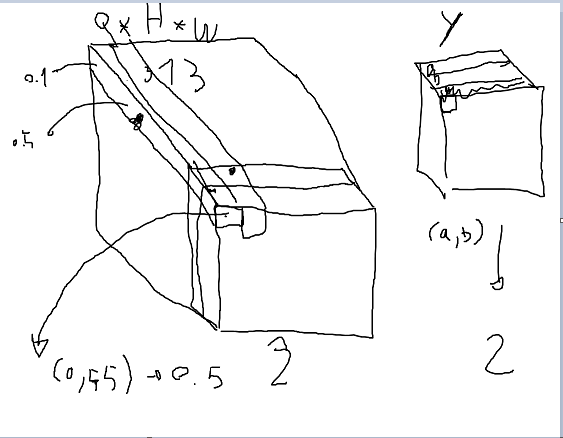

In [21]:
def from_q_to_smallq(original_Q_distribution, mask):
    return original_Q_distribution[mask]


def from_smallq_to_q(small_q_distribution, mask):
    original_q_distribution = torch.zeros(len(mask))

    idx = 0
    for idx_originalq, value in enumerate(mask):
        if value.item() == True:
            original_q_distribution[idx_originalq] = small_q_distribution[idx]
            idx += 1

    return original_q_distribution

In [23]:
def H_inv(ass, bs, mask):
    H, W = ass.shape;
    bin_count = 26;
    Q = bin_count ** 2  # 676

    small_Q = mask.count_nonzero()

    Z = np.zeros((H, W, small_Q))  # Is a Z with newQ dimension

    for h_iter, row in enumerate(ass):
        for w_iter, a in enumerate(row):
            aidx = a // 10  # //floor

            b = bs[h_iter][w_iter]  #pixel          range: 0-255
            bidx = b // 10  # //floor
            distribution = np.zeros((bin_count, bin_count))
            distribution[aidx, bidx] = 1
            distribution = distribution.flatten()

            Z[h_iter][w_iter] = from_q_to_smallq(distribution, mask)  #todo
    return Z

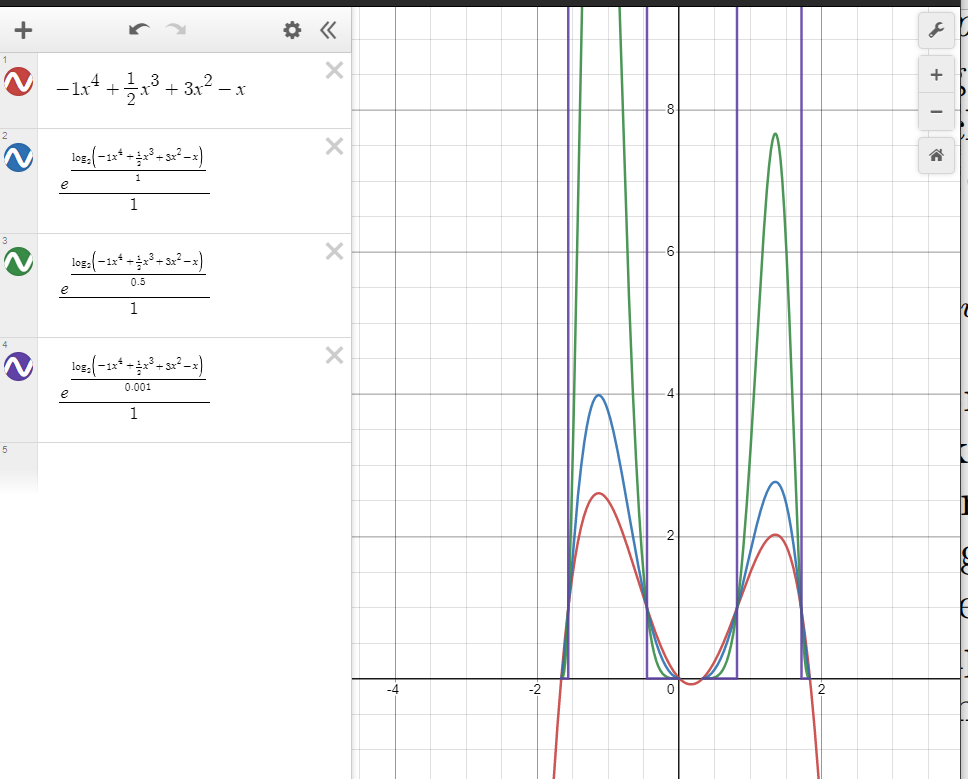

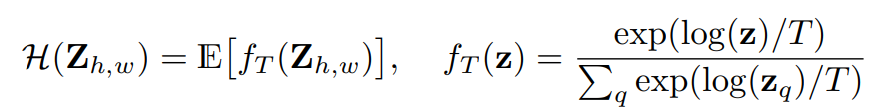

In [25]:
def f_T(z_distribution, T):
    numerator = torch.exp(log(z_distribution) / T)
    denominator = sum(torch.exp(log(z_distribution) / T))
    return numerator / denominator


def H(Z_hw, Q=26 * 26):
    xs = torch.arange(start=0, end=Q, step=1)
    probabilities = f_T(Z_hw, 1)

    # Expected value
    q = torch.round(sum(xs * probabilities), decimals=0)
    q = q.long()  # convert to whole number

    # original_q = get_idx_originalq(q,mask)
    # target_Q = 26**2

    a = torch.div(q, np.sqrt(Q), rounding_mode='trunc') * 10  # floor, same as a // b in python but depricated
    b = q % np.sqrt(Q) * 10

    return a.long(), b.long()

In [27]:
def image_from_Z_and_L(Z, L, Q=222):
    height, width = L.shape
    lab_image = np.zeros((height, width, 3), dtype=np.uint8)
    xs = torch.arange(start=0, end=Q, step=1)
    for h_idx, row in enumerate(Z):
        print(width, h_idx)

        for w_idx, Z_hw in enumerate(row):
            l = L[h_idx, w_idx]

            Z_hw_orig_distr = from_smallq_to_q(Z_hw, mask)  # Z_hw is 222 -> we go to 676 again

            a, b = H(Z_hw_orig_distr, Q)

            lab_image[h_idx][w_idx][0] = l
            lab_image[h_idx][w_idx][1] = a
            lab_image[h_idx][w_idx][2] = b

    return lab_image

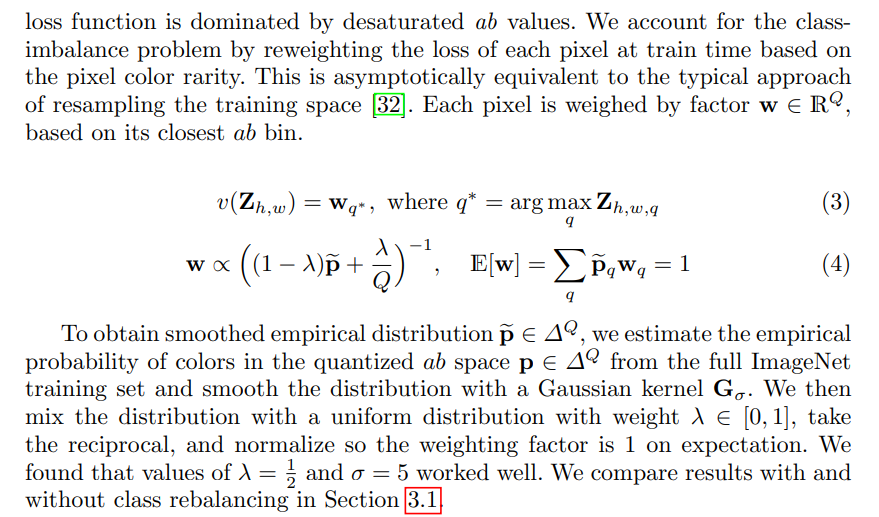

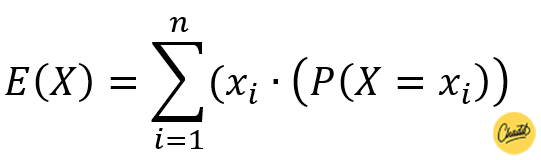

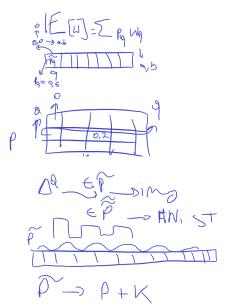

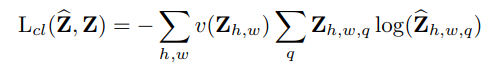

In [28]:
def v(distribution_of_1px):
    pixel_count, Q = distribution_of_1px.shape
    return torch.ones(pixel_count)


# def v(Z, w):
#   idxs = torch.argmax(Z,axis=1) #H*W
#   return w[idxs]

# THE ORDER OF ARGUMENTS MATTERS!!
# FIRST PREDICTION, THEN GROUND TRUTH
def L_cl(z_hat, z):
    assert z_hat.shape == z.shape
    H, W, Q = z_hat.shape

    z_hat_flattened = z_hat.reshape((H * W, Q))
    z_flattened = z.reshape((H * W, Q))

    #                 sum(    R^(H*W)            *  R^(H*W)                                             )
    loss_all_pixels = -1 * sum(v(z_hat_flattened) * sum(z_flattened * log2((z_hat_flattened + 1e-15)), dim=1))
    return loss_all_pixels

# For testing purposes, don't delete pls :)
# def v(distribution_of_1px):
#   return 1
# Same function, but slower and more readable
# def L_cl(z_hat, z):
#   assert z_hat.shape == z.shape
#   H, W, Q = z_hat.shape

#   loss = 0
#   for z_hat_distribution, z_distribution in zip(
#       z_hat.reshape((H * W, Q)), # shape(H, W, Q) -> shape(H * W, Q) for easier iteration
#       z.reshape((H * W, Q))):

#     # take log of each element in distribution
#     # we add small constant to prevent log(0)
#     # warning for small sideeffect: if z_hat is identical to z (which is unlikely),
#     # error may be slightly off (actually negative even, but effect is so small 
#     # and chances of happening are practically zero, so Fabian accepts the risk :)
#     log_z_h_w_hat = log2((z_hat_distribution + 1e-15))
#     loss_single_pixel = v(z_distribution) * sum(z_distribution * log_z_h_w_hat)
#     loss = loss + loss_single_pixel

#   return -1 * loss


# im1 = train_labels[0]
# im2 = train_labels[0]
# im3 = torch.clone(im2)
# im3[0][0][3] = 0.1
# L_cl(im1, im3)

In [31]:
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)


class ImageDataset(Dataset):
    def __init__(self, is_train, random_seed):
        dir = './DATA/imagenet_images'
        paths = [x[0] for x in os.walk(dir)]

        self.filenames = []
        for path in paths:
            self.filenames += [join(path, f) for f in listdir(path) if isfile(join(path, f))]

        # BE WARNED OF THE RANDOM SEED
        # USED FOR OBTAINING SAME TRAIN/TEST SET
        random.Random(random_seed).shuffle(self.filenames)

        length = len(self.filenames)
        index1 = np.floor(length * 0.8).astype(np.int32)
        index2 = (np.floor(length * 0.8) + 1).astype(np.int32)
        self.filenames = self.filenames[:index1] if is_train else self.filenames[index2:]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        try:
            img_path = self.filenames[idx]
            image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)

            # The following line doesn't always work when the original image is grayscale.
            # eg: ./imagenet64/train/n02113799/n02113799_2812.JPEG
            # Hence the try and catch, returning None. Nones get filtered out later by collate_fn
            imageLab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)

            L = imageLab[:, :, 0]
            a = imageLab[:, :, 1]
            b = imageLab[:, :, 2]

            Z = H_inv(a, b, mask)  # mask = global variable
            return L[None, :], Z  #imageLab, Z

        except:
            #the nones will get filtered out, but is necessary in
            # case of corrupted images or grayscale images in dataset
            return None


# Warning! the seed must remain the same!
seed = random.random() * 100
train_dataset = ImageDataset(is_train=True, random_seed=seed)
val_dataset = ImageDataset(is_train=False, random_seed=seed)

batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

test_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [32]:
train_features, train_labels = next(iter(train_dataloader))

In [33]:
test_features, test_labels = next(iter(test_dataloader))

In [ ]:
# Test the H function

# full = train_features[1]
# im1 = train_labels[1]
# im = image_from_Z_and_L(im1, full[:, :, 0], 26*26)
# f = full.to('cpu').numpy()

# im_temp = np.swapaxes(im, 0, 1)
# im_temp.shape
# show([im, im_temp])

# temp = im[:, :, 1]
# im[:, :, 1] = im[:, :, 0]
# im_temp = im[:, :, 0] = temp

In [ ]:
# def compute_p(dataloader,Q_shape = 26**2):
#   p = torch.zeros(Q_shape)
#   for idx, (_, Z_batch) in enumerate(dataloader):
#     if (idx % 50 == 0):
#       print("idx: ",idx)

#     if idx > 100:
#       break

#     for Z in Z_batch:
#       H, W, Q = Z.shape
#       Z_flat = Z.reshape((H * W, Q_shape))
#       p_instance = torch.sum(Z_flat, dim=0)
#       p += p_instance

#   return p/sum(p)

# if must_compute_p:
#   p = compute_p(train_dataloader)
#   torch.save(p, 'p.pt')
#   mask = p>0 #[FAlse, false true ...]
#   torch.save(mask, 'mask.pt')
# else:
#   p = torch.load('p.pt')

In [ ]:
# from scipy.ndimage import gaussian_filter
# p_gaussian = gaussian_filter(p, sigma=5)

In [ ]:
# plt.plot(p.cpu().numpy())

In [ ]:
# plt.plot(p_gaussian)

In [ ]:
# def compute_w(p,lamb,Q):
#   w = 1/ (((1-lamb)* p) + lamb/Q)
#   return w / sum(p*w)

# compute_w(p,lamb,Q)


In [ ]:
# from matplotlib import pyplot as plt
# import cv2

# im = cv2.imread('./imagenet64/train/n01985128/n01985128_29250.JPEG', cv2.IMREAD_UNCHANGED)
# im = cv2.cvtColor(im, cv2.COLOR_BGR2Lab)

# L = im[:, :, 0]
# a = im[:, :, 1]
# b = im[:, :, 2]

# H,W = L.shape
# Q = 313 #possible combinations of (a,b)
# show([im])
# show1D([L,a,b])

In [52]:
from torch import nn


class Model(nn.Module):
    def __init__(self, q_values: int):
        super(Model, self).__init__()
        # TODO normalize

        self.conv1 = self.conv_layer(2, 1, 64, stride=2)
        self.conv2 = self.conv_layer(2, 64, 128, stride=2)
        self.conv3 = self.conv_layer(3, 128, 256, stride=2)
        self.conv4 = self.conv_layer(3, 256, 512)
        self.conv5 = self.conv_layer(3, 512, 512, dilation=2)
        self.conv6 = self.conv_layer(3, 512, 512, dilation=2)
        self.conv7 = self.conv_layer(3, 512, 512)
        self.conv8 = self.conv_layer(3, 512, 256, stride=0.5, normalize=False)

        self.distribution = nn.Conv2d(256, q_values, 1)

        self.output = nn.Sequential(
            nn.Softmax(),  # TODO annealed_softmax, maybe dim=1
            nn.Conv2d(q_values, 2, 1),  # TODO argmax or whatever depending on training or inference
            nn.Upsample(scale_factor=4.0, mode="bilinear")  # TODO denormalize
        )

    @staticmethod
    def conv_layer(depth: int, in_channels: int, out_channels: int, stride: float = 1,
                   dilation: int = 1, normalize: bool = True) -> nn.Sequential:
        layers = []
        for i in range(depth):
            if stride == 0.5 and i == 0:
                layers.append(nn.ConvTranspose2d(in_channels,
                                                 out_channels,
                                                 kernel_size=4,
                                                 stride=2,
                                                 padding=1))
            else:
                layers.append(nn.Conv2d(in_channels if i == 0 else out_channels,
                                        out_channels,
                                        3,
                                        padding=dilation,
                                        stride=stride if i == depth - 1 and stride != 0.5 else 1,
                                        dilation=dilation))
            layers.append(nn.ReLU())

        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.distribution(x)
        return x

In [53]:
model = Model(q_values)

In [54]:
x = train_features.float() / 255.0
model(x).shape

torch.Size([8, 1, 256, 256])
torch.Size([8, 64, 128, 128])
torch.Size([8, 128, 64, 64])
torch.Size([8, 256, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 512, 32, 32])
torch.Size([8, 256, 64, 64])
torch.Size([8, 222, 64, 64])


torch.Size([8, 222, 64, 64])

In [44]:
train_labels.shape

torch.Size([8, 256, 256, 222])

In [ ]:
for X_batch, y_batch in iter(train_dataloader):
    x = X_batch.float() / 255.0
    output = model(x)
    print(output)
    break